# Анализ активности студентов онлайн курса 'Введение в анализ данных в R'.  
# Продолжение. Подготовка данных. Обучение простых моделей.

Переформулируем задачу: как можно раньше предсказать что пользователь уйдёт из курса анализа данных в R.

Загрузим предобработанные данные

In [1]:
import pandas as pd

users_data = pd.read_pickle('./data/students_data.pkl')
events_data = pd.read_pickle('./data/events_data.pkl')

users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


Первый вопрос: можем ли мы, отслеживая поведение студентов за первые n дней, предсказать, что он пройдёт курс до конца или дропнется.

<AxesSubplot:>

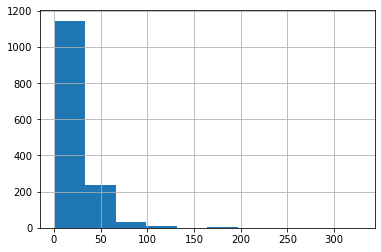

In [2]:
users_data[users_data.passed_course].day.median()
users_data[users_data.passed_course].day.hist()

Пусть n=3

Отберём данные для обучения, события, которые произошли в течение первых 3-х дней

In [3]:
user_min_time = events_data.groupby('user_id', as_index=False).agg({'timestamp': 'min'}).rename({'timestamp': 'min_timestamp'}, axis=1)
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [4]:
users_data = users_data.merge(user_min_time, how='outer')

Для каждого пользователя отберём события от начала до порогового значения n

In [5]:
events_data['user_time'] = events_data.timestamp
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340895


In [6]:
LEARNING_TIME_THRESHOLD = 3 * 24 * 60 * 60

In [7]:
user_learning_time_threshold = user_min_time.min_timestamp + LEARNING_TIME_THRESHOLD
user_learning_time_threshold.head()

0    1473086664
1    1514642564
2    1434617676
3    1466416009
4    1521893860
Name: min_timestamp, dtype: int64

In [8]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340895,1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340895,1434600048


Отберём нужные нам события

In [9]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340895,1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340895,1434600048


---
### Задание
Используя данные о сабмитах найти степ, на котором отваливается максимальное количество студентов.

In [10]:
submissions_data = pd.read_pickle('./data/submissions_data.pkl')
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


Сначала скруппируем данные по id пользователя и выведем последние события пользователей

In [11]:
test_data = submissions_data.groupby(['user_id'], as_index=False).agg({'timestamp': 'max'}).merge(submissions_data, on=['user_id', 'timestamp'], how='left')
test_data.head()

,user_id,timestamp,step_id,submission_status,date,day
0,2,1514383485,32812,correct,2017-12-27 14:04:45,2017-12-27
1,3,1444573728,33538,correct,2015-10-11 14:28:48,2015-10-11
2,5,1499859730,32812,correct,2017-07-12 11:42:10,2017-07-12
3,8,1480604143,33332,correct,2016-12-01 14:55:43,2016-12-01
4,14,1436368601,33983,wrong,2015-07-08 15:16:41,2015-07-08


Отберём события по невыполненому статусу

In [12]:
test_data = test_data[test_data['submission_status'] == 'wrong']
test_data.head()

,user_id,timestamp,step_id,submission_status,date,day
4,14,1436368601,33983,wrong,2015-07-08 15:16:41,2015-07-08
6,17,1465764761,32031,wrong,2016-06-12 20:52:41,2016-06-12
8,25,1524736541,32812,wrong,2018-04-26 09:55:41,2018-04-26
11,31,1485685730,31976,wrong,2017-01-29 10:28:50,2017-01-29
13,34,1505076405,33669,wrong,2017-09-10 20:46:45,2017-09-10


Посчитаем количество пользователей для каждого степа

In [13]:
test_data.groupby(['step_id'], as_index=False).agg({'user_id': 'count'}).sort_values(by='user_id', ascending=False).head(1)

,step_id,user_id
4,31978,154


Опробуем эмпирическое правило: степ на котором будет наибольшее число неверных ответов и является искомым

In [14]:
submissions_data[submissions_data.submission_status == 'wrong'].groupby('step_id', as_index=False).count().sort_values('submission_status').tail(1)

,step_id,timestamp,submission_status,user_id,date,day
4,31978,16084,16084,16084,16084,16084


---

Проверим, что действительно отобрались данные за n дней

In [15]:
events_data_train.groupby('user_id').day.nunique().max()

4

Проделаем то же самое с данными submissions_data

In [16]:
submissions_data['user_time'] = submissions_data.timestamp
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

Финализируем данные для модели МО

In [17]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns={'day': 'days'})
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


Вычислим, сколько степов пытался решить каждый пользователь

In [18]:
step_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index().rename(columns={'step_id': 'steps_tried'})
step_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


In [19]:
X = X.merge(step_tried, on='user_id', how='outer')
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


Добавим данные о событиях

In [20]:
X = X.merge(submissions_data_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index())
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


In [21]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


Добавим данные о количестве просмотренных шагов

In [22]:
X = X.merge(events_data_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


Заполним пустые ячейки нулями

In [23]:
X = X.fillna(0)

Добавим информацию о том, что пользователь в итоге закончил курс успешно (passed_course) и данные о том, что он не пытается это сделать

In [24]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


Отбросим пользователей, которые ещё проходят курс

In [25]:
X = X[X.is_gone_user | X.passed_course]
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

In [26]:
y = X.passed_course.map(int)

In [27]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


Вынесем id пользователей в индексы

In [28]:
X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

Сохраним данные

In [29]:
X.to_pickle('./data/students_data_x.pkl')
y.to_pickle('./data/students_data_y.pkl')

# Примеры применения моделей на подготовленных данных

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Логистическая регрессия

In [31]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=5)

clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9314306893995552


In [32]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(clf, X_train, y_train, cv=4).mean())

0.9193743895579946


### Решающие деревья

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(criterion='entropy')
parameters = {'max_depth': range(3, 6), 'max_leaf_nodes': range(6, 15), 'min_samples_leaf': range(1, 4), 'min_samples_split': range(2, 5)}
grid_search_cv_clf = GridSearchCV(dt, parameters, cv=5)
grid_search_cv_clf.fit(X_train, y_train)

model = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_, cross_val_score(model, X_train, y_train, cv=4).mean())

{'max_depth': 5, 'max_leaf_nodes': 9, 'min_samples_leaf': 1, 'min_samples_split': 2} 0.917547429249292


### Метод k ближайших соседей

In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
parameters = {'n_neighbors': range(15, 25), 'leaf_size': range(1, 7)}
grid_search_cv_clf = GridSearchCV(knn, parameters, cv=4, n_jobs=-1)
grid_search_cv_clf.fit(X_train,y_train)

model = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_, cross_val_score(model, X_train, y_train, cv=4).mean())

{'leaf_size': 1, 'n_neighbors': 16} 0.9174677109237374
